# Importing the packages

In [1]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

In [2]:
mat.rcParams.update({'figure.figsize':(20,15),'font.size':14})

# Reading the files

In [3]:
sales = pd.read_csv('data/video-games-sales.csv')
extra_info = pd.read_csv('data/ign.csv')

# Preprocessing 

## Missing Values

Getting the sales dataset info to check for nan values

In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 10 columns):
Name            16598 non-null object
Platform        16598 non-null object
Year            16327 non-null float64
Genre           16598 non-null object
Publisher       16540 non-null object
NA_Sales        16595 non-null float64
EU_Sales        16595 non-null float64
JP_Sales        16598 non-null float64
Other_Sales     16598 non-null float64
Global_Sales    16598 non-null float64
dtypes: float64(6), object(4)
memory usage: 1.3+ MB


In [5]:
sales.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


Checking nan values in NA_Sales and EU_Sales as they showed lower number of non null values than JP_Sales, Other_Sales and Other_Sales

In [6]:
sales.loc[sales['NA_Sales'].isna()]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
408,The Lord of the Rings: The Return of the King,PS2,2003.0,Action,Electronic Arts,NaN,1.28,0.05,0.46,3.28
600,Madden NFL 08,PS2,2007.0,Sports,Electronic Arts,NaN,0.08,0.00,0.35,2.57
999,Call of Duty: Black Ops 3,X360,2015.0,Shooter,Activision,NaN,0.48,0.00,0.16,1.76


In [7]:
sales.loc[sales['EU_Sales'].isna()]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
108,Mario Kart 8,WiiU,2014.0,Racing,Nintendo,3.13,NaN,1.27,0.49,6.96
200,Super Mario Bros.,GB,1999.0,Platform,Nintendo,3.40,NaN,0.15,0.22,5.07
500,Call of Duty: Finest Hour,PS2,2004.0,Shooter,Activision,1.51,NaN,0.01,0.24,2.89


Fixing both as they can be infered from the other data

In [9]:
sales.loc[sales['NA_Sales'].isna(),'NA_Sales'] = sales.loc[sales['NA_Sales'].isna()][['EU_Sales','JP_Sales','Other_Sales','Global_Sales']].apply(lambda x: x[3] - sum(x[:3]),axis=1) 
sales.loc[sales['EU_Sales'].isna(),'EU_Sales'] = sales.loc[sales['EU_Sales'].isna()][['NA_Sales','JP_Sales','Other_Sales','Global_Sales']].apply(lambda x: x[3] - sum(x[:3]),axis=1) 

Recovering as much release year of the games as possible

In [21]:
sales['Name']= sales['Name'].str.lower().str.strip()
extra_info['title']= extra_info['title'].str.lower().str.strip()

Getting the first chars from each word in the platform name (abbr.)

In [22]:
extra_info["Platform-md"] = extra_info.platform.apply(lambda x: 
                              ''.join(
                                     [word[0] if word.isalpha()
                                       else word
                                        for word in re.sub(r"(\w)([A-Z])", r"\1 \2", x).split()] 
                                  # regular expression sub method takes 3 arguments the pattern, 
                                  # replacment and the original string
                                  # pattern gives says match any word char and the second match any capital char 
                                  # in the case of PlayStation it will match y and S
                                  # replacement uses backreference \1 says choose the first group (y) and \2 the 2nd (S)
                                  # says put space between the matched chars
                                    )
                            )

any platform name that is the same as the original dataset, should be updated in the modified platform in the data used for recovery

In [23]:
extra_info.loc[extra_info.platform.isin(sales["Platform"].unique()),'Platform-md'] = extra_info.loc[extra_info.platform.isin(sales["Platform"].unique())].platform

still unmatched platforms check if the abbr can be set manually

In [24]:
sales.loc[~sales.Platform.isin(extra_info["Platform-md"].unique())].Platform.unique()

array(['DS', 'SNES', '3DS', 'XB', '2600', 'XOne', 'WiiU', 'GEN', 'DC',
       'SAT', 'TG16', '3DO', 'GG', 'PCFX'], dtype=object)

Translating the erroneous abbr. platforms

In [26]:
fixing_platform={
  'NDS': 'DS',
    'N3D':'3DS',
    'WU':'WiiU',
    'X':'XB',
   'XO':'XOne',
    'A2600':'2600',
    'SNE':'SNES',
    'G':'GEN',
    'D':'DC',
    'S':'SAT',
    'TGrafx-16':'TG16'
}

In [27]:
for k in fixing_platform.keys():
     extra_info.loc[extra_info['Platform-md'] == k,'Platform-md']=fixing_platform[k]

Merging the 2 datasets

In [29]:
sales_year_recovered = pd.merge(sales,
                 extra_info.rename(columns={'title':'Name','Platform-md':'Platform'}), 
                 on = ['Name','Platform'],
                 how="left")

updating the years

In [30]:
sales_year_recovered.loc[sales_year_recovered["Year"].isna(),'Year'] = sales_year_recovered.loc[sales_year_recovered["Year"].isna(),'release_year']

In [31]:
sales.columns

Index(['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'NA_Sales%',
       'EU_Sales%', 'JP_Sales%', 'Other_Sales%', 'Rank'],
      dtype='object')

drop any left rows with Nan values in the Year and Publisher columns

In [33]:
sales_year_recovered = sales_year_recovered.dropna(subset=['Year', 'Publisher'],axis=0)

remove any duplicates genrated by the merge

In [34]:
sales_year_recovered = sales_year_recovered[sales_year_recovered.columns[:15]].drop_duplicates(keep='first')

In [35]:
sales_year_recovered.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,NA_Sales%,EU_Sales%,JP_Sales%,Other_Sales%,Rank
0,wii sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,50.145033,35.073725,4.556442,10.224801,1
1,super mario bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,72.266402,8.896620,16.923459,1.913519,2
2,mario kart wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,44.249023,35.957566,10.580681,9.240648,3
3,wii sports resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,47.727273,33.363636,9.939394,8.969697,4
4,pokemon red/pokemon blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,35.926044,28.339178,32.578897,3.187759,5


In [36]:
sales_year_recovered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16410 entries, 0 to 16628
Data columns (total 15 columns):
Name            16410 non-null object
Platform        16410 non-null object
Year            16410 non-null float64
Genre           16410 non-null object
Publisher       16410 non-null object
NA_Sales        16410 non-null float64
EU_Sales        16410 non-null float64
JP_Sales        16410 non-null float64
Other_Sales     16410 non-null float64
Global_Sales    16410 non-null float64
NA_Sales%       16410 non-null float64
EU_Sales%       16410 non-null float64
JP_Sales%       16410 non-null float64
Other_Sales%    16410 non-null float64
Rank            16410 non-null int64
dtypes: float64(10), int64(1), object(4)
memory usage: 2.0+ MB


## Feature Engineering

Transforming categorical variables Genre and Publisher to dummy values

In [10]:
sales_dummies = pd.concat([sales.drop(['Genre','Publisher'],1),pd.get_dummies(sales[['Genre','Publisher']],dummy_na = False,drop_first=True)],sort=False)

Calculating the percentage of game sales in each region from the total sales

In [11]:
for col in sales.columns[5:9]:
    sales[col + '%'] = (sales[col]/sales[sales.columns[9]]) * 100 

In [12]:
sales.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,NA_Sales%,EU_Sales%,JP_Sales%,Other_Sales%
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,50.145033,35.073725,4.556442,10.224801
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,72.266402,8.896620,16.923459,1.913519
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,44.249023,35.957566,10.580681,9.240648
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,47.727273,33.363636,9.939394,8.969697
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,35.926044,28.339178,32.578897,3.187759


Create the rank column

In [38]:
sales['Rank'] = sales.index + 1

Calculating the percentage of game global sales from the total global sales

In [41]:
sales['Global_Sales%'] = round((sales['Global_Sales']/sales['Global_Sales'].sum())*100,4)

Creating a new column for the cummulative sum of the game global sales percentages

In [43]:
sales['Global_Sales - CumSum'] = sales['Global_Sales%'].cumsum()

sales.head()

# Exploratory Analysis

## Summary Statistics

In [47]:
sales[['NA_Sales%','EU_Sales%','JP_Sales%','Other_Sales%','Global_Sales']].describe()

,NA_Sales%,EU_Sales%,JP_Sales%,Other_Sales%,Global_Sales
count,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000
mean,45.551841,22.921170,24.234136,6.459174,0.537441
std,34.082452,24.929715,40.167127,7.939307,1.555028
min,0.000000,0.000000,0.000000,0.000000,0.010000
25%,0.000000,0.000000,0.000000,0.000000,0.060000
50%,50.000000,20.000000,0.000000,5.555556,0.170000
75%,75.000000,37.500000,35.103826,10.253283,0.470000
max,100.000000,100.000000,100.000000,100.000000,82.740000


- North America has the highest average for games sales about 46% and std of 34% (median of 50%)
- Japan follows with average of about 24% and std of 40%
- average sales for the game is 0.537M USD and the median (0.17M) 
- 75% of the games had under 0.47M sales

In [71]:
sales.groupby('Genre')[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']].sum().sort_values('Global_Sales',ascending=False)

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Genre,,,,,
Action,877.82,525.00,159.95,187.38,1751.18
Sports,683.35,376.85,135.37,134.97,1330.93
Shooter,582.61,313.28,38.28,102.69,1037.37
Role-Playing,327.28,188.06,352.31,59.61,927.37
Platform,447.05,201.63,130.77,51.59,831.37
Misc,410.24,215.98,107.76,75.32,809.96
Racing,359.42,238.39,56.69,77.27,732.04
Fighting,223.59,101.32,87.35,36.68,448.91
Simulation,183.31,113.38,63.70,31.52,392.20


- Here we see the action games has the highest sum of sales in comparison with other Gernre
- Sports follows it
- Strategy games had the lowest sales.

In [74]:
sales.sort_values('Global_Sales').tail(1)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,NA_Sales%,EU_Sales%,JP_Sales%,Other_Sales%,Rank,Global_Sales%,Global_Sales - CumSum
0,wii sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,50.145033,35.073725,4.556442,10.224801,1,0.9275,0.9275


In [75]:
sales.sort_values('NA_Sales').tail(1)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,NA_Sales%,EU_Sales%,JP_Sales%,Other_Sales%,Rank,Global_Sales%,Global_Sales - CumSum
0,wii sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,50.145033,35.073725,4.556442,10.224801,1,0.9275,0.9275


In [76]:
sales.sort_values('EU_Sales').tail(1)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,NA_Sales%,EU_Sales%,JP_Sales%,Other_Sales%,Rank,Global_Sales%,Global_Sales - CumSum
0,wii sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,50.145033,35.073725,4.556442,10.224801,1,0.9275,0.9275


In [77]:
sales.sort_values('JP_Sales').tail(1)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,NA_Sales%,EU_Sales%,JP_Sales%,Other_Sales%,Rank,Global_Sales%,Global_Sales - CumSum
4,pokemon red/pokemon blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.0,31.37,35.926044,28.339178,32.578897,3.187759,5,0.3517,2.5017


In [78]:
sales.sort_values('Other_Sales').tail(1)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,NA_Sales%,EU_Sales%,JP_Sales%,Other_Sales%,Rank,Global_Sales%,Global_Sales - CumSum
17,grand theft auto: san andreas,PS2,2004.0,Action,Take-Two Interactive,9.43,0.4,0.41,10.57,20.81,45.314753,1.922153,1.970207,50.792888,18,0.2333,6.159


In [79]:
sales_year = sales_year_recovered.groupby('Year')['Global_Sales'].sum().reset_index()

In [80]:
# top 5 years 
sales_year.sort_values(['Global_Sales']).tail()

,Year,Global_Sales
26,2006.0,525.06
30,2010.0,604.22
27,2007.0,611.45
29,2009.0,668.08
28,2008.0,689.69


In [81]:
sales_year['Year'] = pd.to_datetime(sales_year['Year'],format='%Y')

<Figure size 1080x720 with 0 Axes>

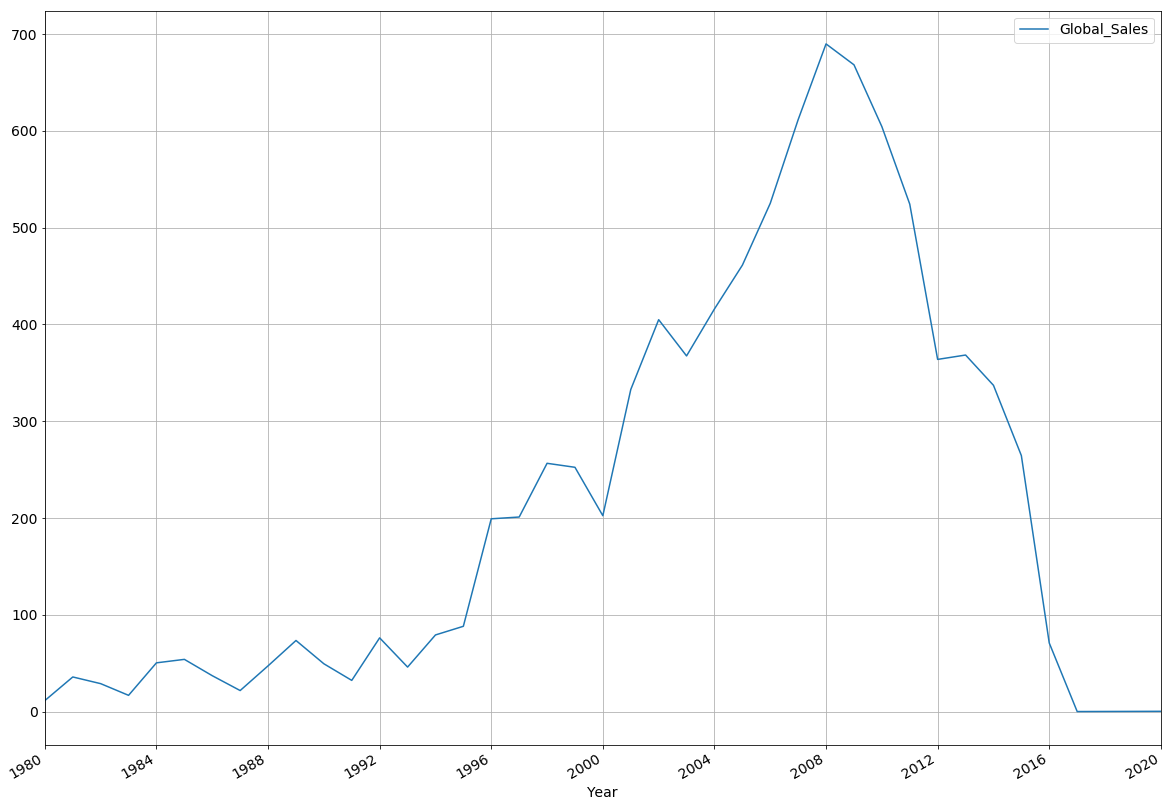

In [82]:
plt.figure(figsize=(15,10))
sales_year.set_index('Year').plot(grid=True)
plt.show()

- 2008 had the highest sales
- the sales were trending up before 2008 and after it started to trend down "needs more analysis in this area"

In [98]:
games_year = sales_year_recovered.groupby('Year')['Name'].count().reset_index().rename(columns={'Name':'Total Games'})

In [99]:
# top 5 years 
games_year.sort_values(['Total Games'],ascending=False).head()

,Year,Total Games
28,2008.0,1442
29,2009.0,1437
30,2010.0,1267
27,2007.0,1206
31,2011.0,1152


In [100]:
games_year['Year'] = pd.to_datetime(games_year['Year'],format='%Y')

<Figure size 1080x720 with 0 Axes>

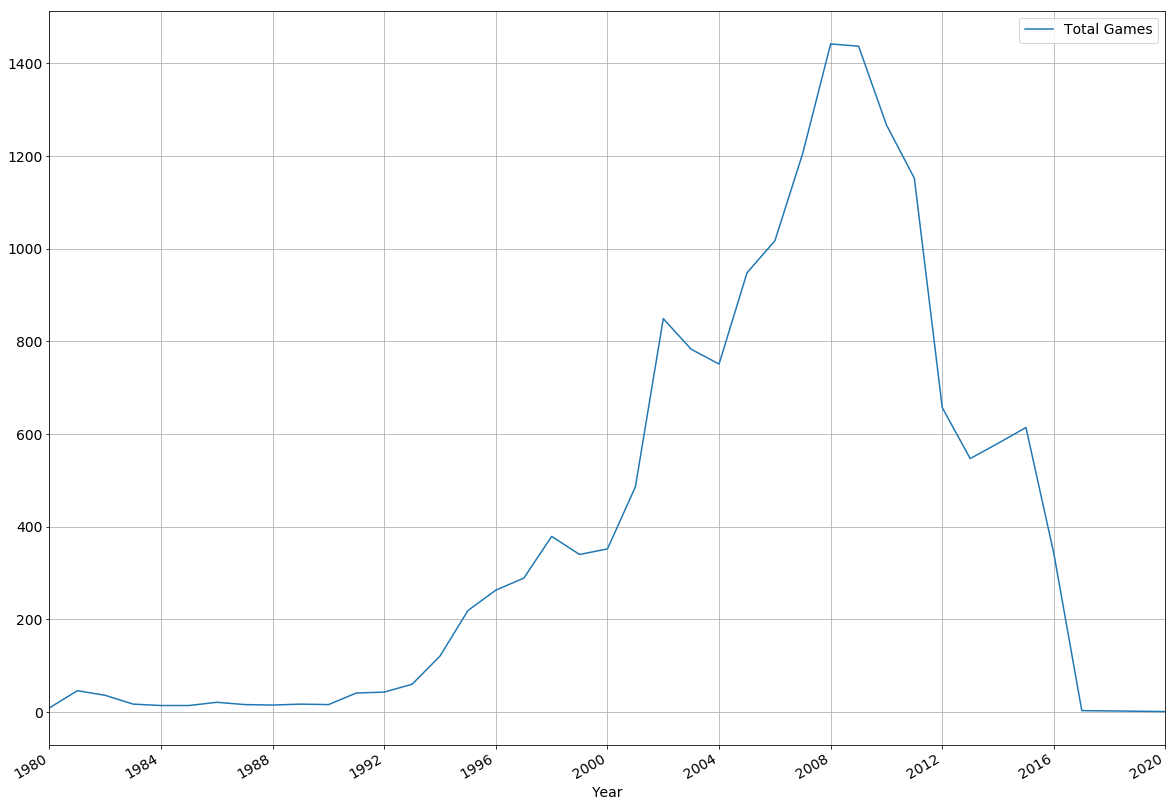

In [101]:
plt.figure(figsize=(15,10))
games_year.set_index('Year').plot(grid=True)
plt.show()

- The data shows that 2008 had the highest number of released games
- Same pattern is shown by the games total by year explianing how the two might be correlated 

In [103]:
sales_games_year = games_year.set_index('Year').join(sales_year.set_index('Year'))

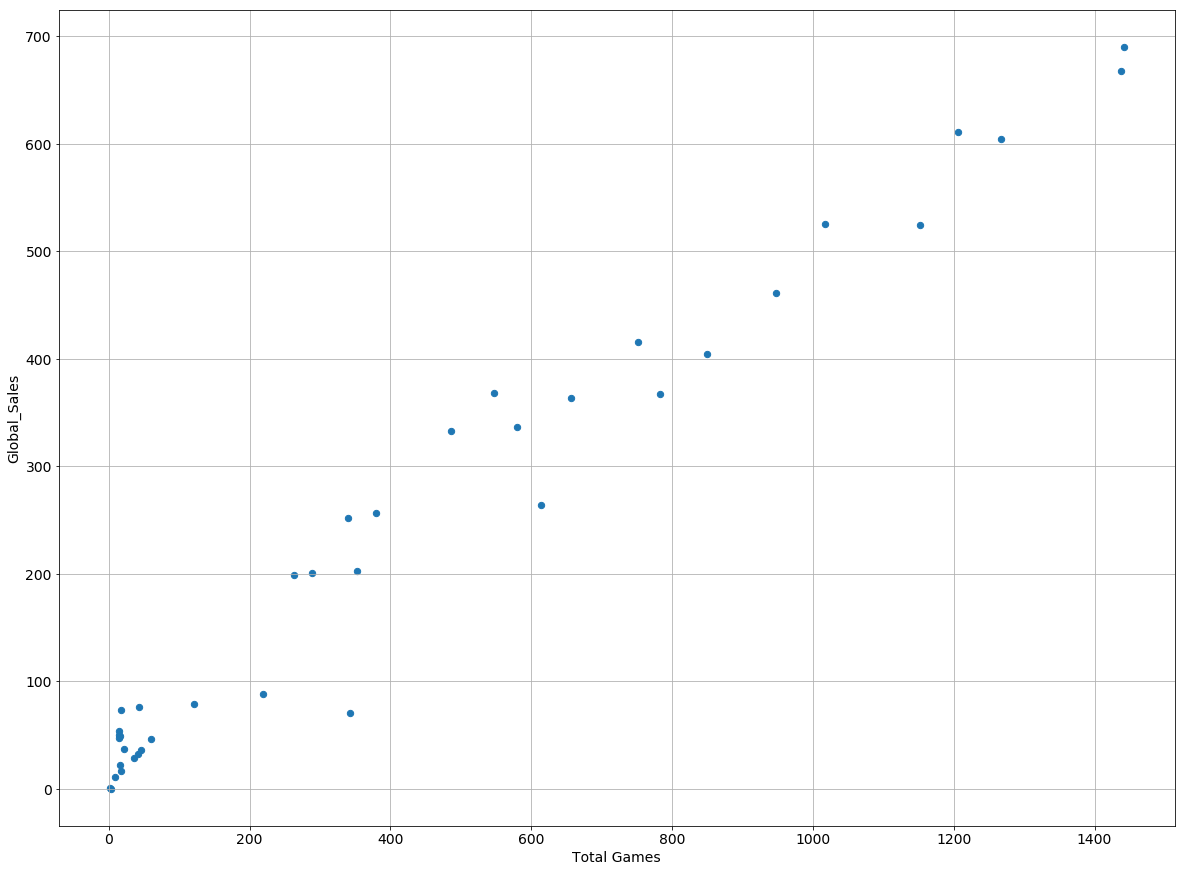

In [110]:
sales_games_year.plot.scatter(x='Total Games', y='Global_Sales',s=40)
plt.grid()

In [104]:
sales_games_year.corr()

,Total Games,Global_Sales
Total Games,1.000000,0.983486
Global_Sales,0.983486,1.000000


- High correlation between both the two time series data (#Games , Sales total) 

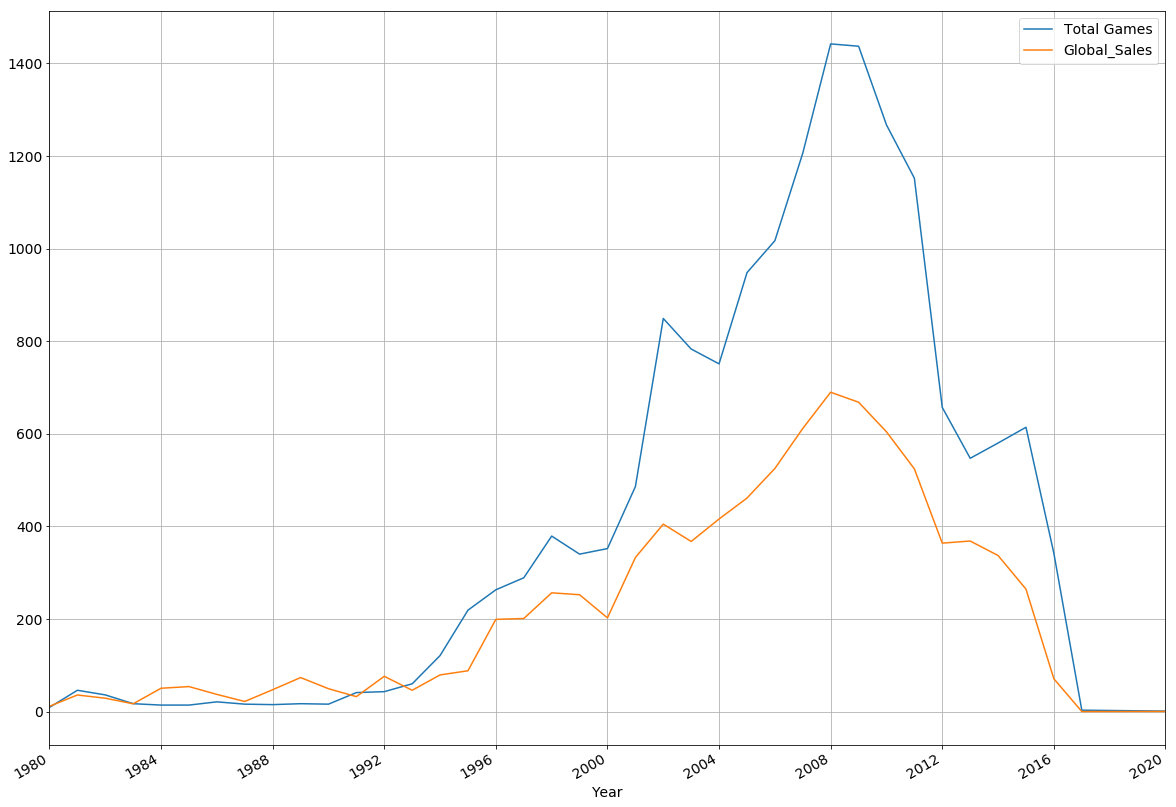

In [105]:
sales_games_year.plot(grid=True)

In [115]:
sales.loc[sales['Year'] == 2008].groupby('Genre')['Name'].count().sort_values()

Genre
Strategy         50
Fighting         57
Platform         62
Puzzle           64
Racing           82
Shooter          83
Role-Playing    112
Simulation      119
Adventure       166
Sports          200
Misc            212
Action          221
Name: Name, dtype: int64

- action, Misc and Sports were the highest Genre in this year

In [116]:
sales_genre_region = sales.groupby('Genre')[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']].mean().reset_index()

In [117]:
sales_genre_region.sort_values('NA_Sales',ascending=False).head(1)

,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
4,Platform,0.504571,0.227573,0.147596,0.058228,0.938341


- Interestingly, the average sales per game per Genre in North Amarica is the highest in the platform games where in average the game brought more than half a million.
- interesting giving that the highest total sales in North Amarica were in Action genre

In [130]:
sales.replace({0:np.nan}).groupby('Genre')[['NA_Sales']].count().sort_values('NA_Sales').tail(1)

,NA_Sales
Genre,
Action,2582


In [133]:
sales.replace({0:np.nan}).groupby('Genre')[['NA_Sales']].sum().sort_values('NA_Sales').tail(1)

,NA_Sales
Genre,
Action,877.82


In [131]:
sales.replace({0:np.nan}).groupby('Genre')[['NA_Sales']].count().sort_values('NA_Sales').loc['Platform']

NA_Sales    800
Name: Platform, dtype: int64

In [132]:
sales.replace({0:np.nan}).groupby('Genre')[['NA_Sales']].sum().sort_values('NA_Sales').loc['Platform']

NA_Sales    447.05
Name: Platform, dtype: float64

- Action has the highest number of games in America so when it got divided by the total sales the share of each game shrinked

In [66]:
sales_genre_region.sort_values('EU_Sales',ascending=False).head(1)

,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
8,Shooter,0.44474,0.239145,0.029221,0.078389,0.791885


- Here Eroupe had the shooter with near half million for the game

In [135]:
sales.replace({0:np.nan}).groupby('Genre')[['EU_Sales']].count().sort_values('EU_Sales').tail(1)

,EU_Sales
Genre,
Action,2460


In [136]:
sales.replace({0:np.nan}).groupby('Genre')[['EU_Sales']].sum().sort_values('EU_Sales').tail(1)

,EU_Sales
Genre,
Action,525.0


In [137]:
sales.replace({0:np.nan}).groupby('Genre')[['EU_Sales']].count().sort_values('EU_Sales').loc['Shooter']

EU_Sales    1081
Name: Shooter, dtype: int64

In [138]:
sales.replace({0:np.nan}).groupby('Genre')[['EU_Sales']].sum().sort_values('EU_Sales').loc['Shooter']

EU_Sales    313.28
Name: Shooter, dtype: float64

In [67]:
sales_genre_region.sort_values('JP_Sales',ascending=False).head(1)

,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
7,Role-Playing,0.219946,0.126384,0.236767,0.04006,0.623233


- Japan sticks with the Role-Playing genre with the highest average per game

In [139]:
sales.replace({0:np.nan}).groupby('Genre')[['JP_Sales']].count().sort_values('JP_Sales').tail(1)

,JP_Sales
Genre,
Action,1166


In [141]:
sales.replace({0:np.nan}).groupby('Genre')[['EU_Sales']].sum().sort_values('EU_Sales').loc['Action']

EU_Sales    525.0
Name: Action, dtype: float64

In [142]:
sales.replace({0:np.nan}).groupby('Genre')[['JP_Sales']].count().sort_values('JP_Sales').loc['Role-Playing']

JP_Sales    1052
Name: Role-Playing, dtype: int64

In [143]:
sales.replace({0:np.nan}).groupby('Genre')[['JP_Sales']].sum().sort_values('JP_Sales').tail(1)

,JP_Sales
Genre,
Role-Playing,352.31


In [68]:
sales_genre_region.sort_values('Other_Sales',ascending=False).head(1)

,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
8,Shooter,0.44474,0.239145,0.029221,0.078389,0.791885


- Here other had the shooter with near 80,000 for the game

In [157]:
sales_genre_region = sales.groupby('Genre')[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']].sum().reset_index()

In [158]:
sales_genre_region = sales_genre_region.set_index('Genre').rename(columns={'NA_Sales':'North America Sales',
                                                     'EU_Sales':'Europe Sales',
                                                     'JP_Sales':'Japan Sales',
                                                     'Other_Sales':'Other Sales'})

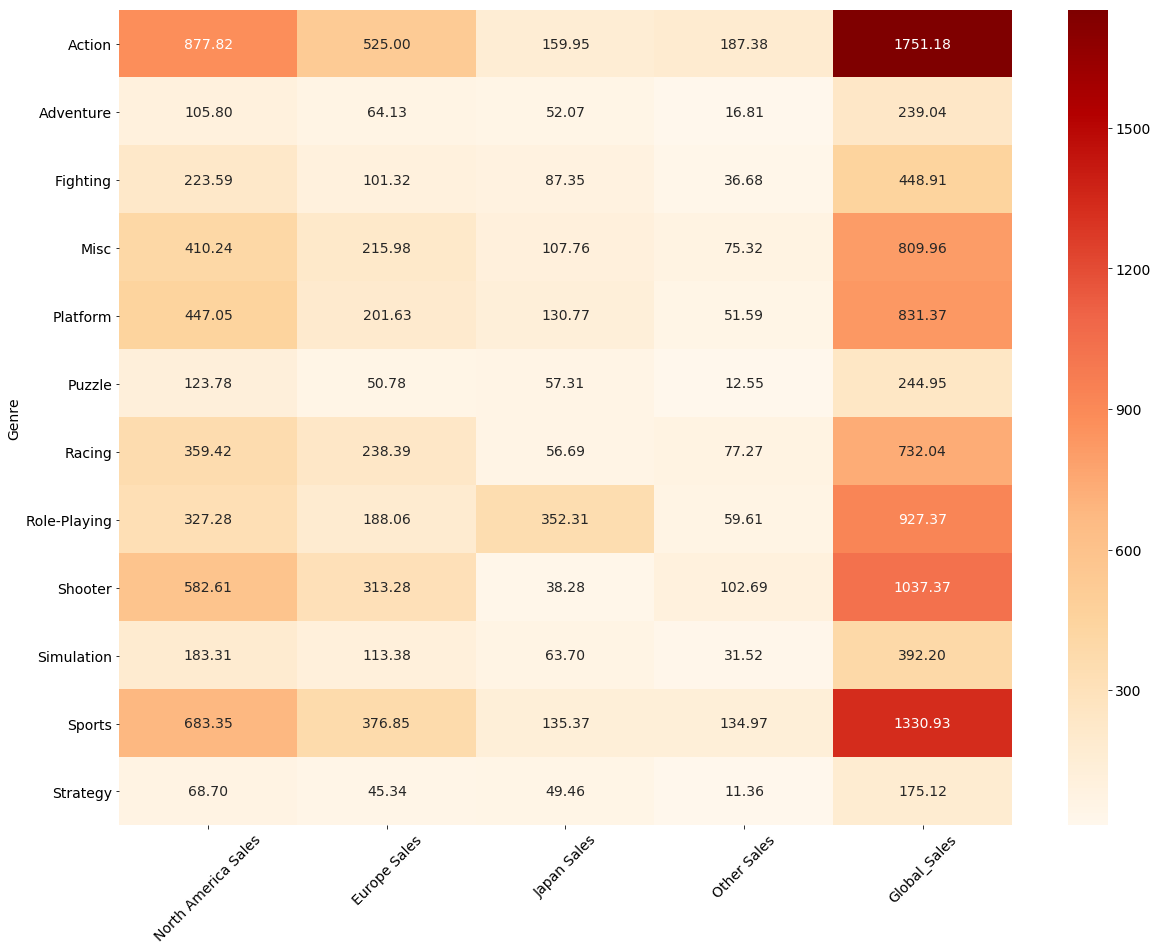

In [159]:
sns.heatmap(sales_genre_region,cmap="OrRd",annot=True,fmt=".2f")
plt.xticks(rotation=45)
plt.show()

In [248]:
sales_genre_region.sort_values('Global_Sales',ascending=False).head(1)

,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,Action,877.82,525.0,159.95,187.38,1751.18


In [147]:
sales_platform_region = sales.groupby('Platform')[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']].sum().reset_index()

In [148]:
sales_platform_region.sort_values('NA_Sales',ascending=False).head(1)

,Platform,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
28,X360,601.06,280.58,12.43,85.54,979.96


In [149]:
sales_platform_region.sort_values('EU_Sales',ascending=False).head(1)

,Platform,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
17,PS3,392.26,343.71,79.99,141.93,957.84


In [150]:
sales_platform_region.sort_values('JP_Sales',ascending=False).head(1)

,Platform,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
4,DS,390.71,194.65,175.57,60.53,822.49


In [151]:
sales_platform_region.sort_values('Other_Sales',ascending=False).head(1)

,Platform,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
16,PS2,583.83,339.3,139.2,193.44,1255.64


In [152]:
sales_platform_region.sort_values('Global_Sales',ascending=False).head(1)

,Platform,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
16,PS2,583.83,339.3,139.2,193.44,1255.64


In [153]:
sales_platform_region = sales_platform_region.set_index('Platform').rename(columns={'NA_Sales':'North America Sales',
                                                     'EU_Sales':'Europe Sales',
                                                     'JP_Sales':'Japan Sales',
                                                     'Other_Sales':'Other Sales'})

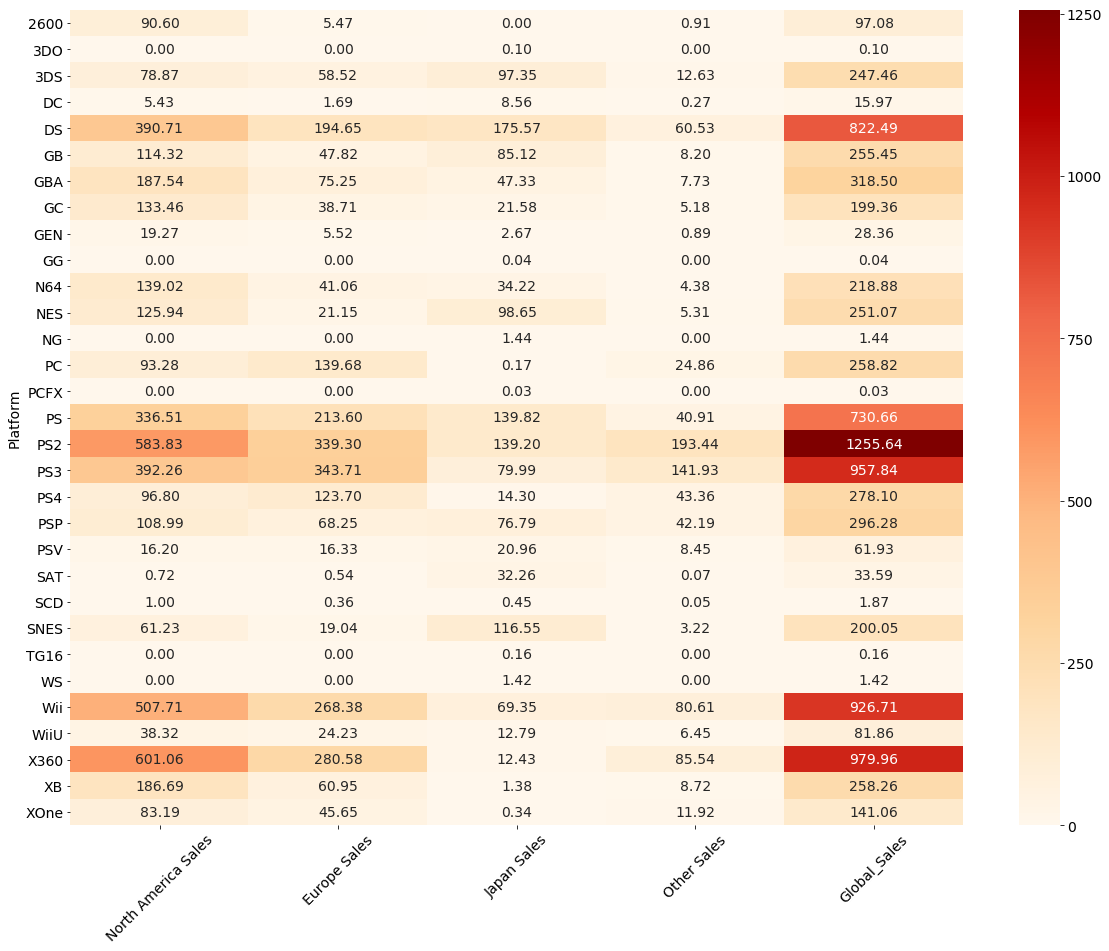

In [155]:
sns.heatmap(sales_platform_region,cmap="OrRd",annot=True,fmt=".2f")
plt.xticks(rotation=45)
plt.show()

- Xbox 360 North America highest
- PS3 in Europe
- DS in Japan
- PS2 in Other areas

In [160]:
sales_melted = pd.melt(sales.rename(columns={'NA_Sales':'North America Sales',
                                                     'EU_Sales':'Europe Sales',
                                                     'JP_Sales':'Japan Sales',
                                                     'Other_Sales':'Other Sales'}), id_vars = ['Name','Genre','Platform'], value_vars = ['North America Sales','Europe Sales','Japan Sales','Other Sales'])

In [161]:
sales_melted = sales_melted.rename(columns={'variable':'Region','value':'Sales'})

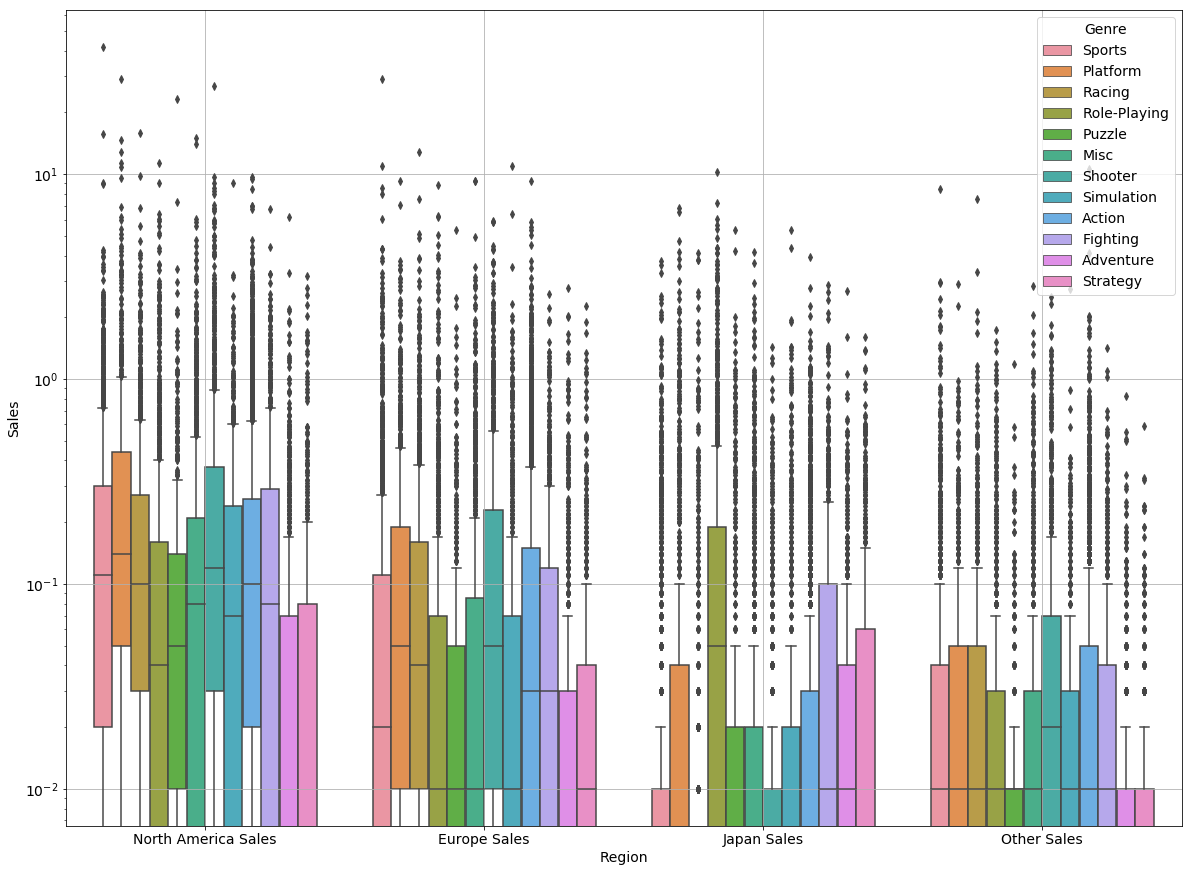

In [162]:
sns.boxplot(x='Region',y='Sales', hue = 'Genre', data=sales_melted)
plt.yscale('log')
plt.grid()

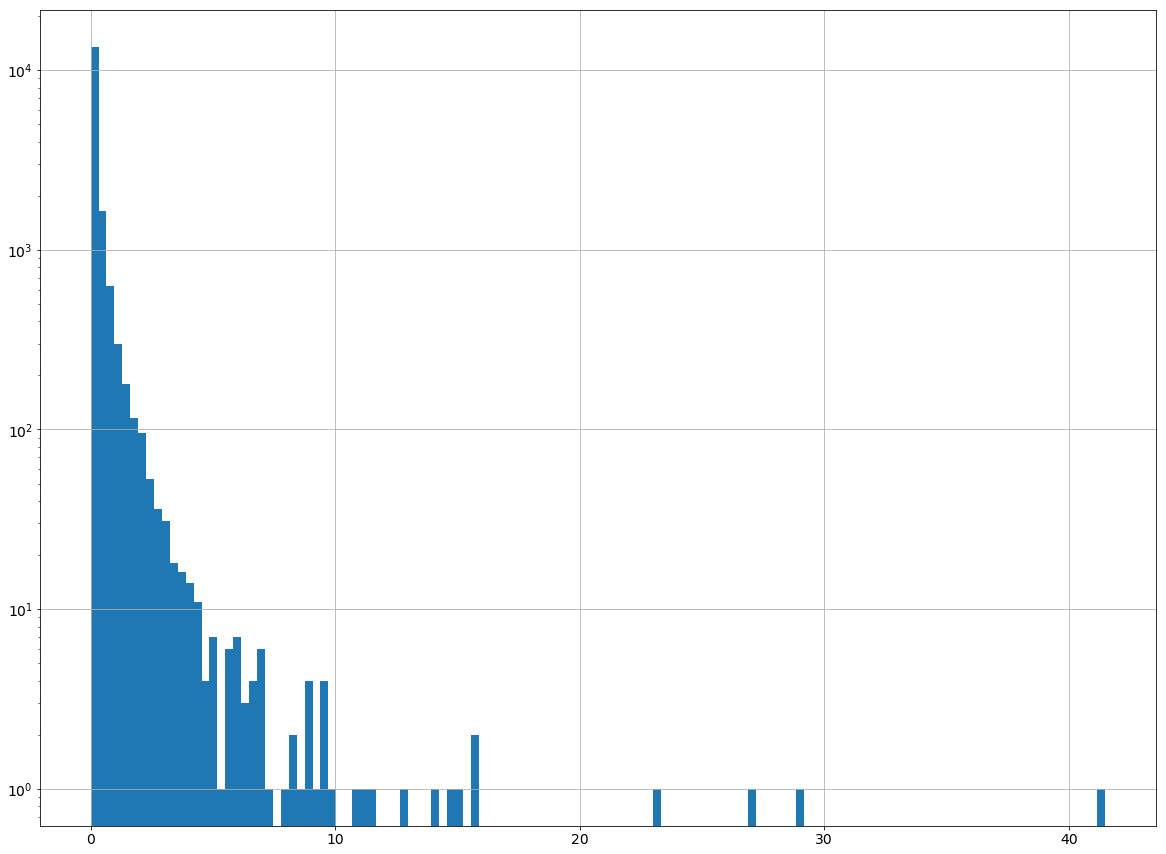

In [164]:
sales['NA_Sales'].hist(bins=int(np.sqrt(len(sales))))
plt.yscale('log')

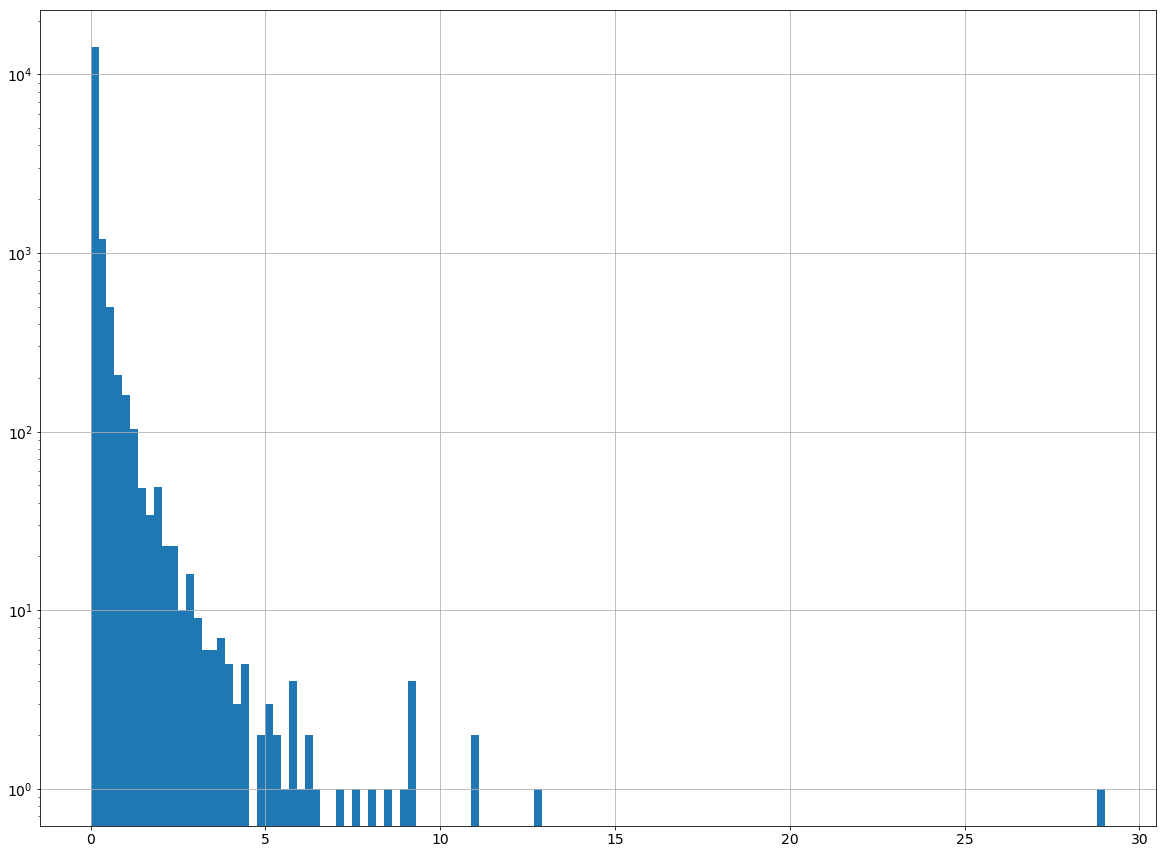

In [165]:
sales['EU_Sales'].hist(bins=int(np.sqrt(len(sales))))
plt.yscale('log')

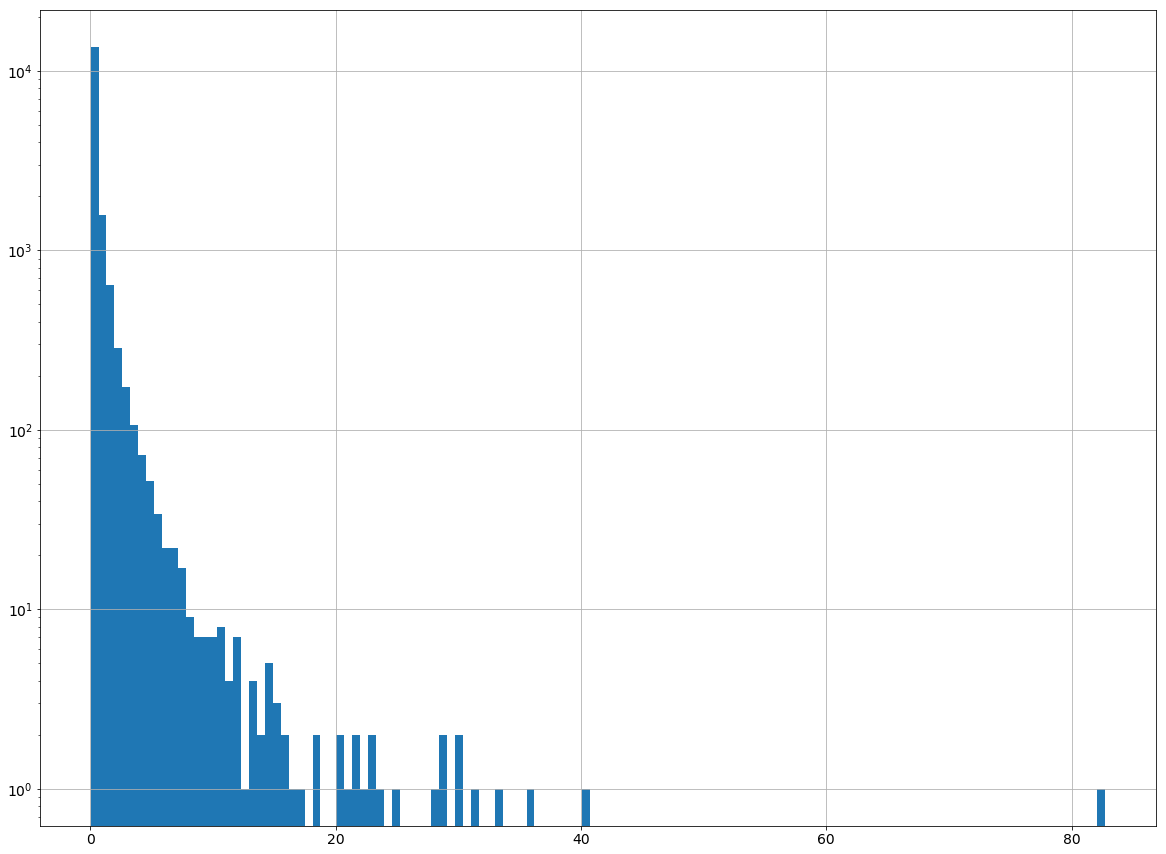

In [166]:
sales['Global_Sales'].hist(bins=int(np.sqrt(len(sales))))
plt.yscale('log')

## Pareto Analysis

In [167]:
sales_pareto_80 = sales.loc[(sales['Global_Sales - CumSum'] <= 80)].copy()
sales_pareto_20 = sales.loc[(sales['Global_Sales - CumSum'] > 80)].copy()

In [168]:
sales['Global_Sales'].sum()*0.8

7136.352000000001

In [170]:
sales_pareto_80['Global_Sales'].sum()

7135.629999999999

In [172]:
round((len(sales_pareto_80)/len(sales))*100)

25

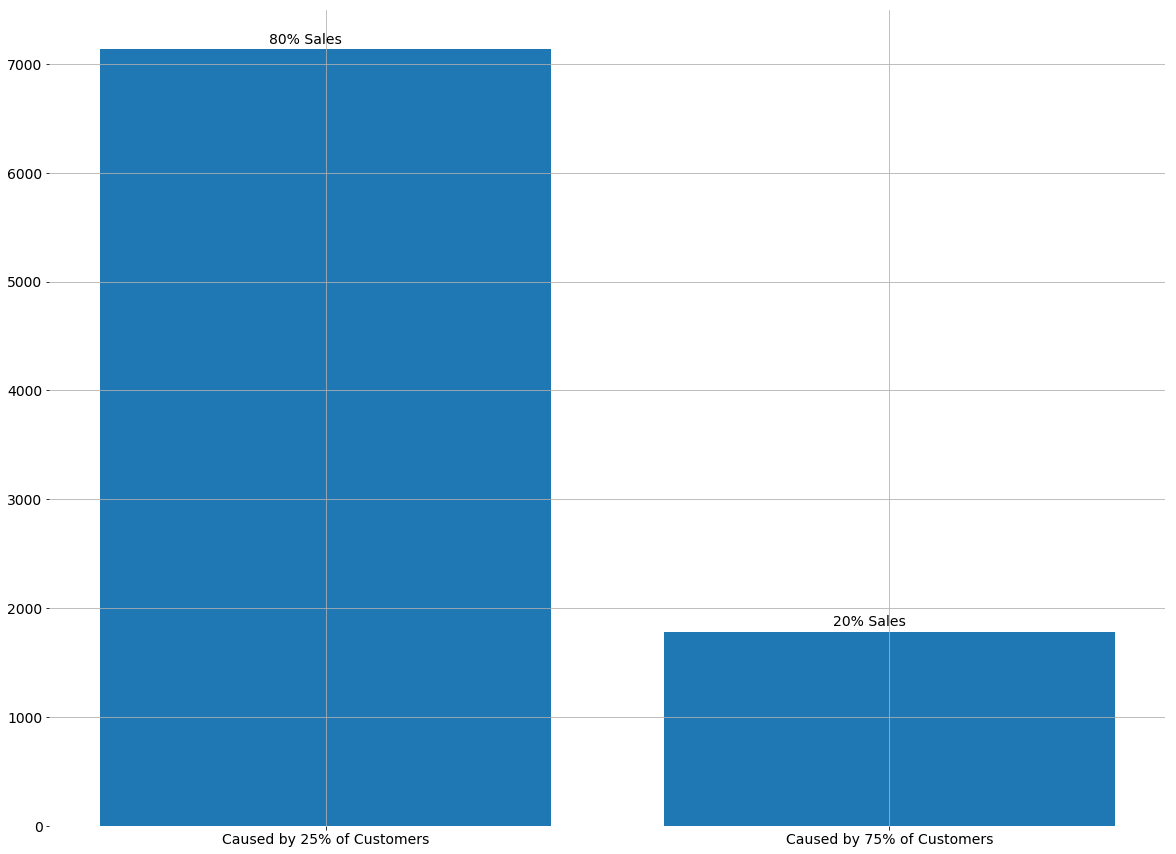

In [173]:
plt.bar([1,2],[sales_pareto_80['Global_Sales'].sum(),sales_pareto_20['Global_Sales'].sum()])
plt.xticks([1,2],['Caused by 25% of Customers','Caused by 75% of Customers'])
plt.grid()
plt.gca().set_frame_on(False)
plt.gca().text(1-0.1,sales_pareto_80['Global_Sales'].sum()+50,'80% Sales')
plt.gca().text(2-0.1,sales_pareto_20['Global_Sales'].sum()+50,'20% Sales')
    
plt.show()

In [175]:
len(sales)

16598

- from a total of 16598 game, the 1/4 only were resposible of 80% total sales 

## 80% Sales 

In [185]:
sales_pareto_80.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False).head()

Genre
Action          1374.69
Sports          1052.85
Shooter          910.15
Role-Playing     772.82
Platform         740.88
Name: Global_Sales, dtype: float64

In [186]:
sales_pareto_80.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False).head()

Platform
PS2     1005.69
X360     842.24
PS3      821.40
Wii      769.07
DS       596.57
Name: Global_Sales, dtype: float64

In [187]:
sales_pareto_80.groupby('Year')['Global_Sales'].sum().sort_values(ascending=False).head()

Year
2008.0    534.75
2009.0    501.63
2007.0    486.51
2010.0    466.89
2006.0    423.62
Name: Global_Sales, dtype: float64